* [1.Data Overview](#1.Data&nbsp;Overview)
   * [1.1&nbsp;Introduction](#11)
   * [1.2&nbsp;data&nbsp;preprocessing](#12)
* [2.visualization](#2.visualization)
   * [2.1&nbsp;visualization&nbsp;for&nbsp;Tokyo](#21)
   * [2.2&nbsp;visualization&nbsp;for&nbsp;Osaka](#22)
   * [2.3&nbsp;visualization&nbsp;for&nbsp;New&nbsp;York](#23)



# 1.Data&nbsp;Overview


<h3 id="11">1.1&nbsp;Introduction</h3>
There are 7 csv in city-lines.I only use 5 csv in this kernel,'track_lines.csv', 'cities.csv', 'lines.csv', 'stations.csv',and 'tracks.csv'.The data size is 9757,334,1343,15794,and 9271 respectively.





In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import pylab as pl
import geopandas as gpd
import folium
from folium import plugins



In [2]:
print(os.listdir("../input/city-lines/"))

['track_lines.csv', 'systems.csv', 'cities.csv', 'lines.csv', 'stations.csv', 'tracks.csv', 'station_lines.csv']


In [3]:
cities=pd.read_csv("../input/city-lines/cities.csv")
stations=pd.read_csv("../input/city-lines/stations.csv")
tracks=pd.read_csv("../input/city-lines/tracks.csv")
lines=pd.read_csv("../input/city-lines/lines.csv")
track_lines=pd.read_csv("../input/city-lines/track_lines.csv")
print("cities size:",len(cities))
print("stations size:",len(stations))
print("tracks size:",len(tracks))
print("lines size:",len(lines))
print("track_lines size:",len(track_lines))

cities size: 334
stations size: 15794
tracks size: 9271
lines size: 1343
track_lines size: 9757


<h3 id="12">1.2&nbsp;data&nbsp;preprocessing</h3>

First,we drop out the NA from closure,name,and opening in stations.csv.I visuzlize the station which is not close,so I need to choose the stations which station.closure is greater than 9999.

stations.csv has a problem about the opening number is 999999.So I have to drop out it.

id_country is the dataframe,including cities.id,cities.country,and cities.name.

Finally,stations merge with id_country.

In [4]:
stations=stations.dropna(subset=['closure','name','opening'])
stations=stations[stations.closure>=9999]
stations=stations[stations.opening>0]
stations=stations[stations.opening<=2030]
stations.columns=['id','stations_name','geometry','buildstart','opening','closure','city_id']
stations['Long']=stations['geometry'].apply(lambda x: x.split('POINT(')[1].split(' ')[0])
stations['Lat']=stations['geometry'].apply(lambda x: x.split('POINT(')[1].split(' ')[1].split(')')[0])
id_country=pd.DataFrame({'city_id':cities.id,'country':cities.country,'name':cities.name})

stations=pd.merge(stations,id_country)
stations.head()

id          stations_name                                  geometry  \
0  7694       Keisei Tsudanuma  POINT(140.024812197129 35.6837744784723)   
1  7695  Keisei Makuhari-Hongo  POINT(140.042146725175 35.6726021159981)   
2  7696        Keisei Makuhari  POINT(140.056077093286 35.6605591225961)   
3  7697               Kemigawa  POINT(140.066304589107 35.6526280375642)   
4  7698           Keisei Inage  POINT(140.085607402414 35.6378035803563)   

   buildstart  opening   closure  city_id              Long               Lat  \
0      1921.0   1921.0  999999.0      114  140.024812197129  35.6837744784723   
1      1991.0   1991.0  999999.0      114  140.042146725175  35.6726021159981   
2      1921.0   1921.0  999999.0      114  140.056077093286  35.6605591225961   
3      1921.0   1921.0  999999.0      114  140.066304589107  35.6526280375642   
4      1921.0   1921.0  999999.0      114  140.085607402414  35.6378035803563   

  country   name  
0   Japan  Tokyo  
1   Japan  Tokyo  
2   Japan  Tokyo  
3   Japan  Tokyo  
4   Japan  Tokyo

# 2.visualization


According to the left bar chart,we know that Top 3 city by stations is Tokyo,Osaka,and New York.You can have detail about the three cities in section 2.1 to 2.3.From the right bar chart,we know that most of stations are from Japan in stations.csv.

Text(0.5, 0, 'stations')

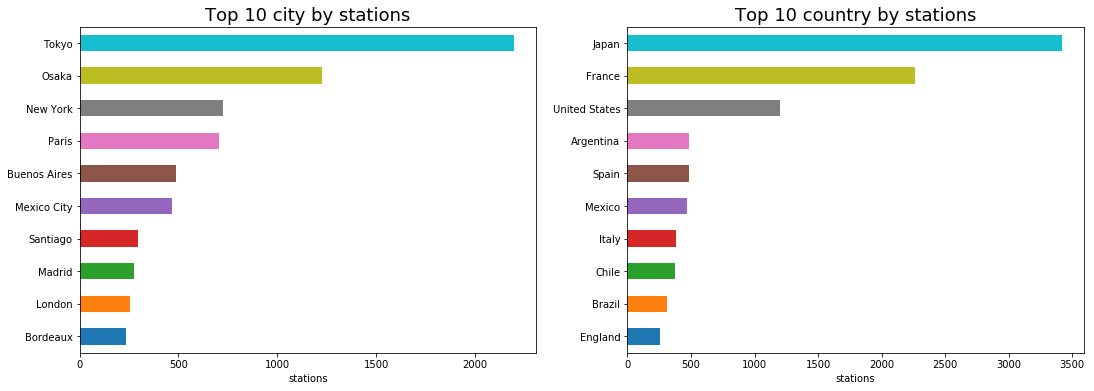

In [5]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1) 
stations.name.value_counts()[:10].sort_values().plot.barh()
plt.title("Top 10 city by stations",size=18)
plt.xlabel("stations")
plt.subplot(1, 2, 2) 
stations.country.value_counts()[:10].sort_values().plot.barh()
plt.title("Top 10 country by stations",size=18)
plt.xlabel("stations")

Text(0.5, 1.0, 'The number of opening stations by year (all country)')

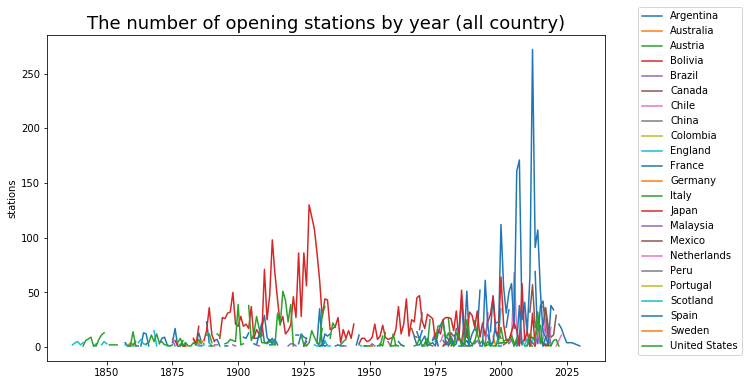

In [6]:
fig,ax=plt.subplots(figsize=(10,6))
stations.groupby(['opening','country'])['stations_name'].agg('count').unstack().plot(ax=ax)
plt.legend(loc=0, bbox_to_anchor=(1.05,1.1))
plt.xlabel('')
plt.ylabel('stations')
plt.title("The number of opening stations by year (all country)",size=18)

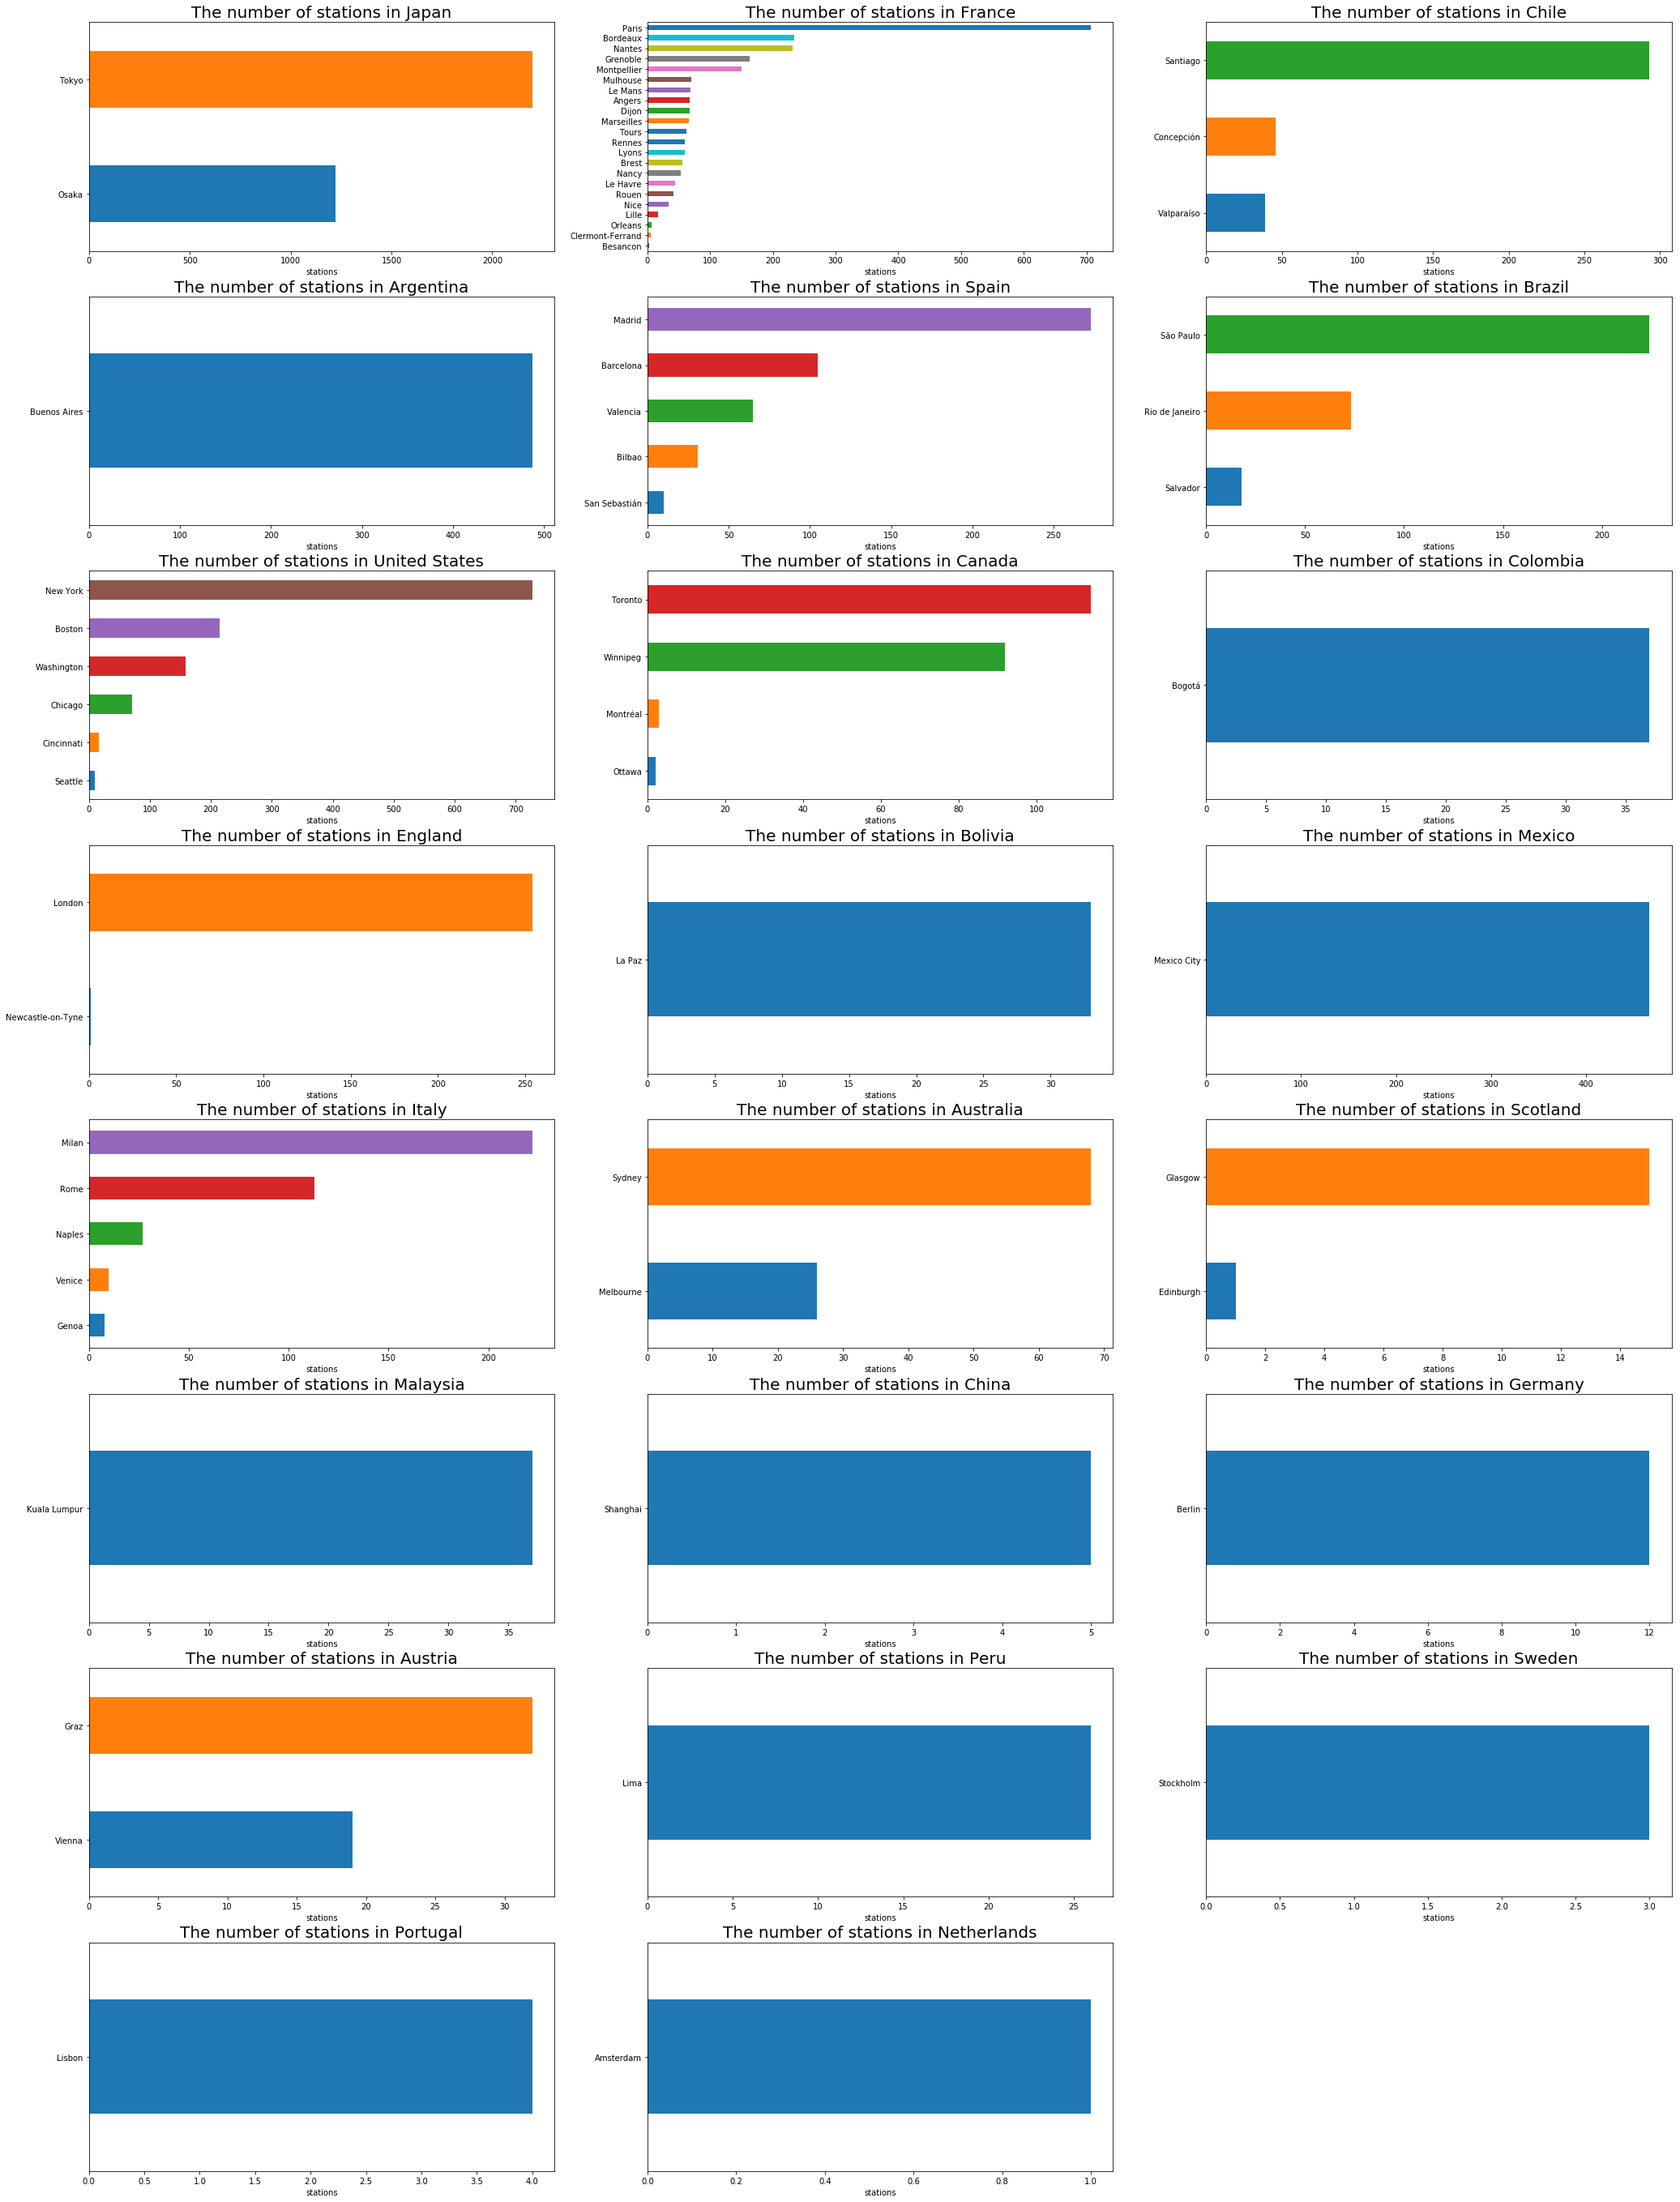

In [7]:
plt.figure(figsize=(35,55))
for i in range(len(stations.country.unique())):
    plt.subplot(9,3,i+1)
    stations[stations.country==stations.country.unique()[i]].name.value_counts().sort_values().plot.barh()
    plt.xlabel('stations')
    plt.title("The number of stations in "+stations.country.unique()[i],size=20)


According to this heatmap,we have the distribution about the number of stations.

In [8]:
map_all=folium.Map()
stations_new=pd.DataFrame({"Lat":stations['Lat'],"Long":stations['Long']})
map_all.add_child(plugins.HeatMap(data=stations_new))

map_all

<h3 id="21">2.1&nbsp;visualization&nbsp;for&nbsp;Tokyo</h3>

In [9]:
tokyo_lines=lines[lines.city_id==114]
tokyo_track_lines=track_lines[track_lines.city_id==114]
tokyo_tracks=tracks[tracks.city_id==114].drop(columns=['buildstart','opening','closure','city_id'])
tokyo_tracks.columns=['section_id','geometry','length']
tokyo_track_lines=pd.merge(tokyo_track_lines,tokyo_tracks)
tokyo_track_lines=tokyo_track_lines.drop(columns=['id','created_at','updated_at','city_id'])
tokyo_track_lines.columns=['section_id','id','geometry','length']
tokyo_lines=pd.merge(tokyo_track_lines,tokyo_lines)
tokyo_stations=stations[stations['city_id']==114]
tokyo_stations.head()

id          stations_name                                  geometry  \
0  7694       Keisei Tsudanuma  POINT(140.024812197129 35.6837744784723)   
1  7695  Keisei Makuhari-Hongo  POINT(140.042146725175 35.6726021159981)   
2  7696        Keisei Makuhari  POINT(140.056077093286 35.6605591225961)   
3  7697               Kemigawa  POINT(140.066304589107 35.6526280375642)   
4  7698           Keisei Inage  POINT(140.085607402414 35.6378035803563)   

   buildstart  opening   closure  city_id              Long               Lat  \
0      1921.0   1921.0  999999.0      114  140.024812197129  35.6837744784723   
1      1991.0   1991.0  999999.0      114  140.042146725175  35.6726021159981   
2      1921.0   1921.0  999999.0      114  140.056077093286  35.6605591225961   
3      1921.0   1921.0  999999.0      114  140.066304589107  35.6526280375642   
4      1921.0   1921.0  999999.0      114  140.085607402414  35.6378035803563   

  country   name  
0   Japan  Tokyo  
1   Japan  Tokyo  
2   Japan  Tokyo  
3   Japan  Tokyo  
4   Japan  Tokyo

Text(0.5, 1.0, 'Top 10 line by number')

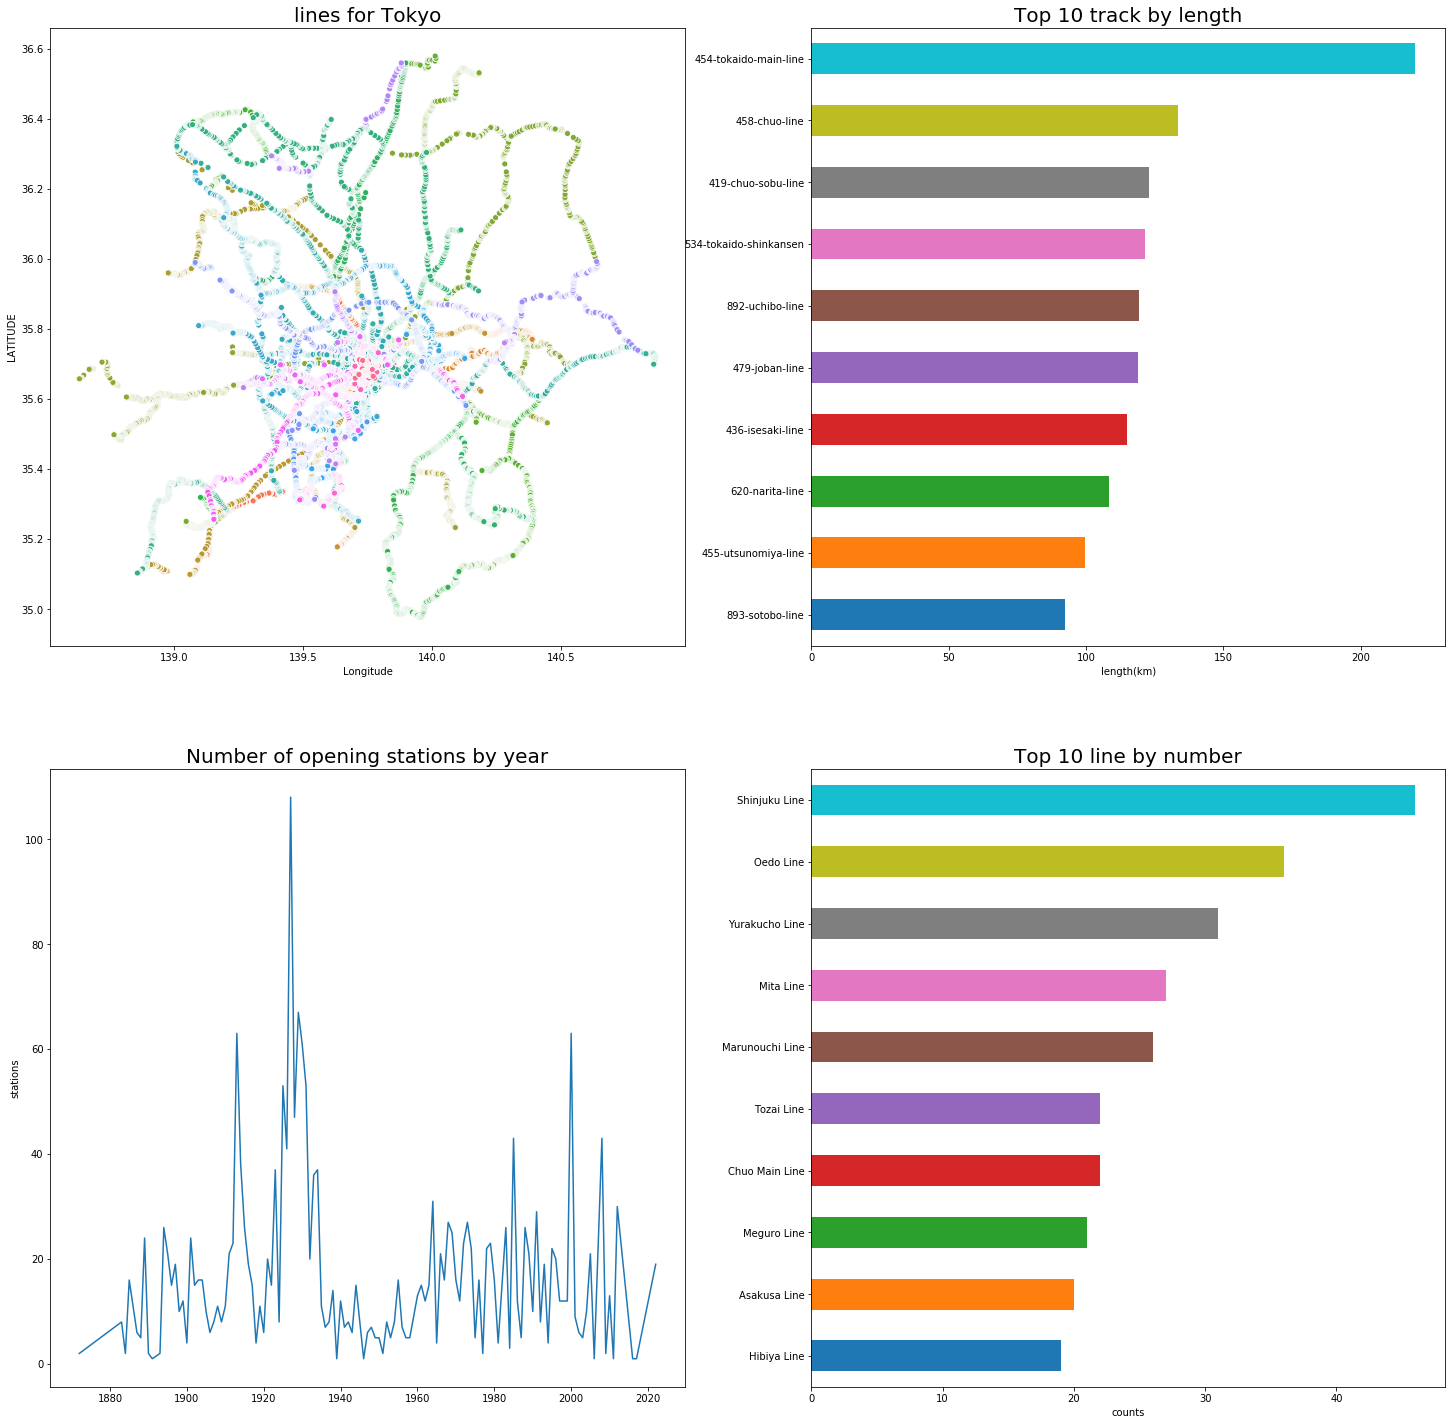

In [10]:
x=[]
y=[]
z=[]
for i in range(len(tokyo_lines)):
    sp=tokyo_lines.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
    for j in range(len(sp)):
        x.append(sp[j].split(' ')[0])
        y.append(sp[j].split(' ')[1])
        z.append(tokyo_lines.url_name[i])
fix=pd.DataFrame({'x':x,'y':y,'z':z})
fix['x']=fix['x'].astype(float)
fix['y']=fix['y'].astype(float)
plt.figure(figsize=(25, 25))
plt.subplot(2, 2, 1) 
ax=sns.scatterplot(x="x", y="y", hue="z",data=fix)
plt.legend(loc=0, bbox_to_anchor=(1.05,0.6))
plt.title("lines for Tokyo",size=20)
ax.get_legend().remove()
ax.set(xlabel='Longitude', ylabel='LATITUDE')
plt.subplot(2,2,2)
(tokyo_lines.groupby(['url_name'])['length'].sum()/1000).sort_values(ascending= False)[:10].sort_values().plot.barh()
plt.ylabel(' ')
plt.xlabel('length(km)')
plt.title("Top 10 track by length",size=20)
plt.subplot(2,2,3)
tokyo_stations.groupby(['opening'])['id'].agg('count').plot()
plt.xlabel(' ')
plt.ylabel('stations')
plt.title("Number of opening stations by year",size=20)
plt.subplot(2,2,4)
tokyo_lines.name.value_counts()[:10].sort_values().plot.barh()
plt.xlabel('counts')
plt.title("Top 10 line by number",size=20)

In [11]:

stations_tokyo_2000=stations[stations['city_id']==114][0:2000]
Long=139.75
Lat=35.67
tokyo_map=folium.Map([Lat,Long],zoom_start=12)

tokyo_stations_map=plugins.MarkerCluster().add_to(tokyo_map)
for lat,lon,label in zip(stations_tokyo_2000.Lat,stations_tokyo_2000.Long,stations_tokyo_2000.stations_name):
    folium.Marker(location=[lat,lon],icon=None,popup=label).add_to(tokyo_stations_map)
tokyo_map.add_child(tokyo_stations_map)

tokyo_map


<h3 id="22">2.2&nbsp;visualization&nbsp;for&nbsp;Osaka</h3>

In [12]:
osaka_lines=lines[lines.city_id==91]
osaka_track_lines=track_lines[track_lines.city_id==91]
osaka_tracks=tracks[tracks.city_id==91].drop(columns=['buildstart','opening','closure','city_id'])
osaka_tracks.columns=['section_id','geometry','length']
osaka_track_lines=pd.merge(osaka_track_lines,osaka_tracks)
osaka_track_lines=osaka_track_lines.drop(columns=['id','created_at','updated_at','city_id'])
osaka_track_lines.columns=['section_id','id','geometry','length']
osaka_lines=pd.merge(osaka_track_lines,osaka_lines)
osaka_stations=stations[stations['city_id']==91]
osaka_stations.head()

id          stations_name                                  geometry  \
5752  16509         Taga-Taishamae  POINT(136.284362823132 35.2264684822925)   
5753   9735                  Umeda   POINT(135.49758315242 34.7033510292888)   
5754  13724  Tenjinbashi-rokuchome  POINT(135.511363701185 34.7107824835462)   
5755  13780               Ogimachi  POINT(135.510846296961 34.7042623408506)   
5756  13725            Nakazakicho  POINT(135.505358301022 34.7069092830841)   

      buildstart  opening   closure  city_id              Long  \
5752      1914.0   1914.0  999999.0       91  136.284362823132   
5753      1933.0   1933.0  999999.0       91   135.49758315242   
5754      1969.0   1969.0  999999.0       91  135.511363701185   
5755      1969.0   1969.0  999999.0       91  135.510846296961   
5756      1974.0   1974.0  999999.0       91  135.505358301022   

                   Lat country   name  
5752  35.2264684822925   Japan  Osaka  
5753  34.7033510292888   Japan  Osaka  
5754  34.7107824835462   Japan  Osaka  
5755  34.7042623408506   Japan  Osaka  
5756  34.7069092830841   Japan  Osaka

Text(0.5, 1.0, 'Top 10 line by number')

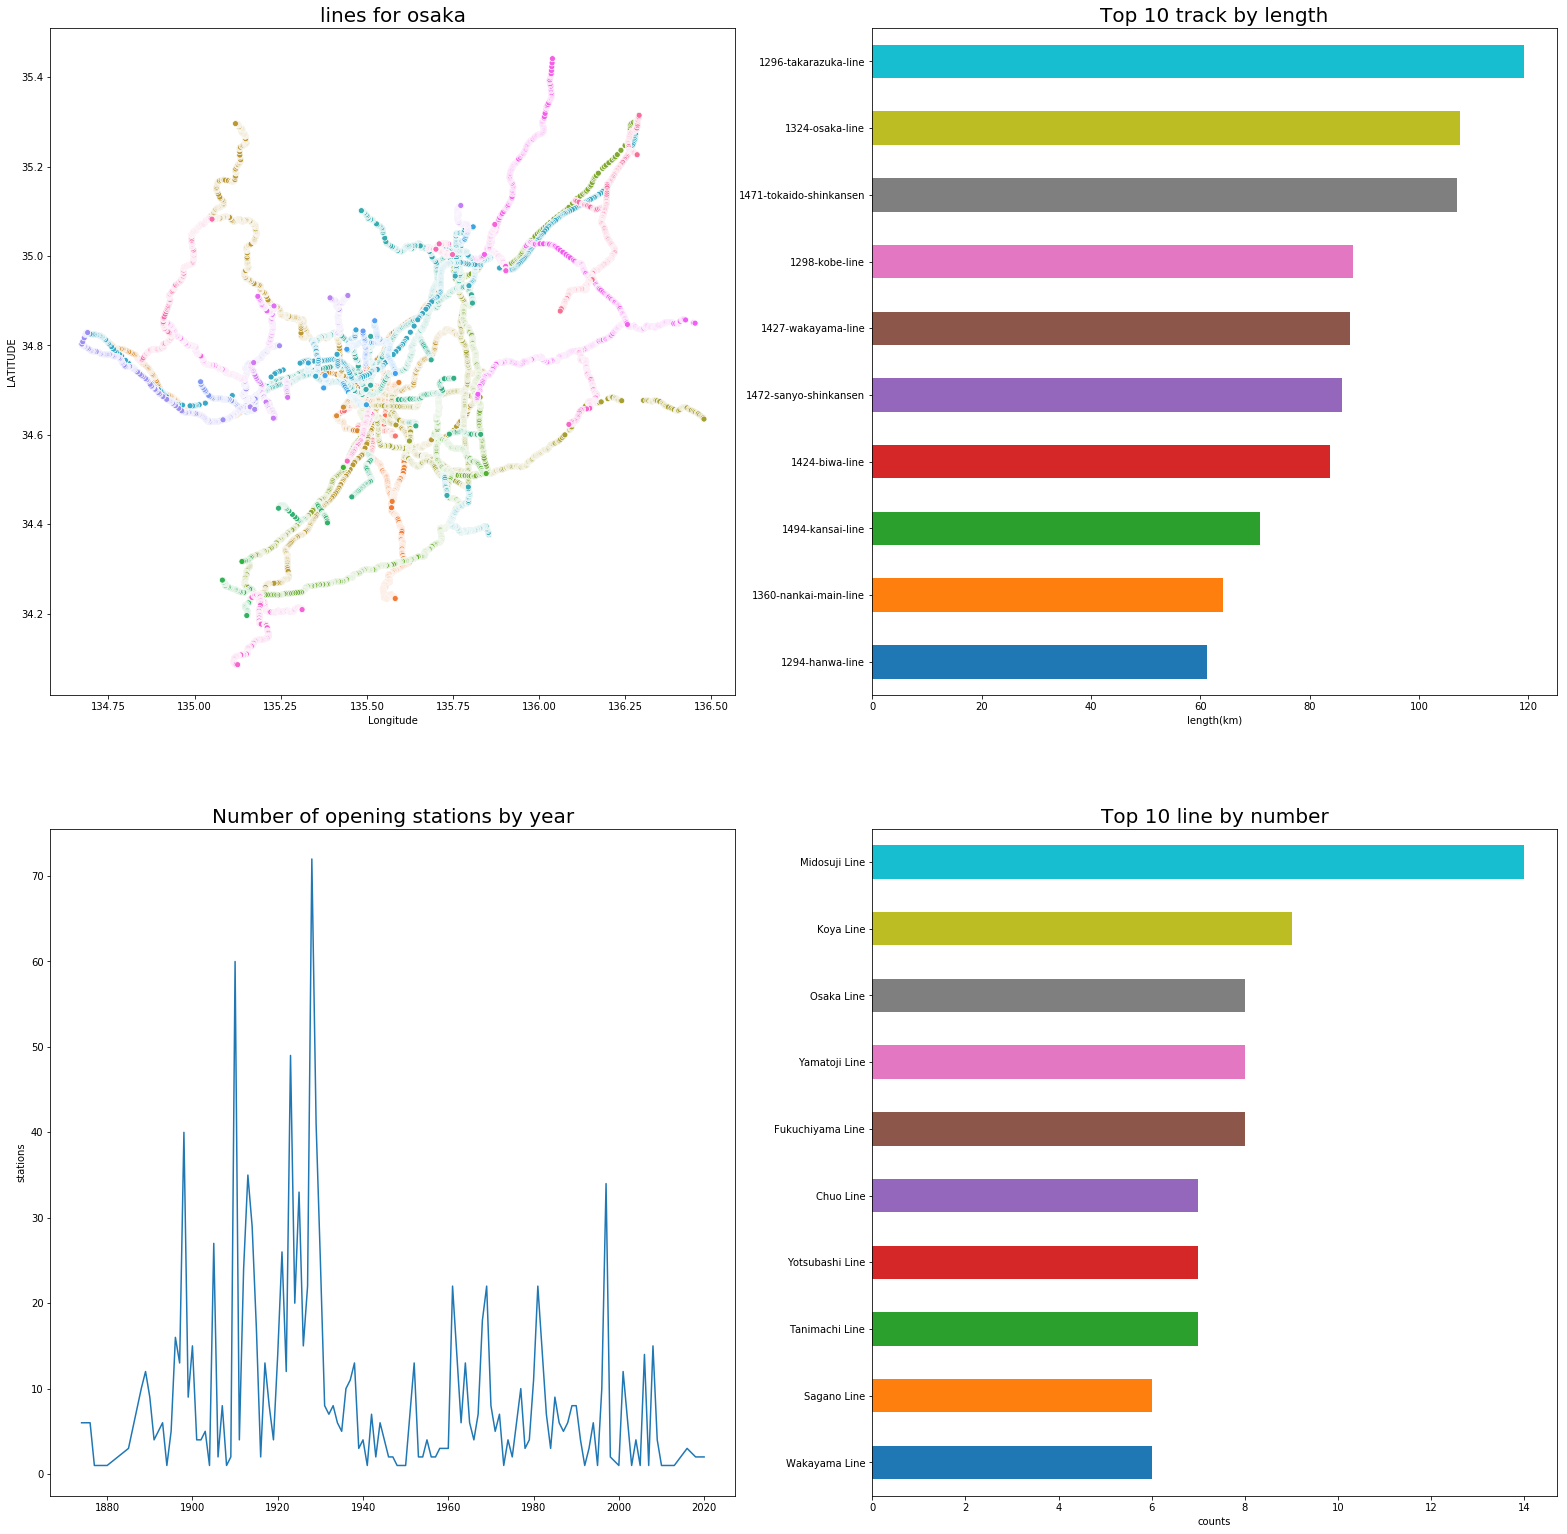

In [13]:
x=[]
y=[]
z=[]
for i in range(len(osaka_lines)):
    sp=osaka_lines.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
    for j in range(len(sp)):
        x.append(sp[j].split(' ')[0])
        y.append(sp[j].split(' ')[1])
        z.append(osaka_lines.url_name[i])
fix=pd.DataFrame({'x':x,'y':y,'z':z})
fix['x']=fix['x'].astype(float)
fix['y']=fix['y'].astype(float)
plt.figure(figsize=(27, 27))
plt.subplot(2, 2, 1) 
ax=sns.scatterplot(x="x", y="y", hue="z",data=fix)
plt.legend(loc=0, bbox_to_anchor=(1.05,0.6))
plt.title("lines for osaka",size=20)
ax.get_legend().remove()
ax.set(xlabel='Longitude', ylabel='LATITUDE')
plt.subplot(2,2,2)
(osaka_lines.groupby(['url_name'])['length'].sum()/1000).sort_values(ascending= False)[:10].sort_values().plot.barh()
plt.ylabel(' ')
plt.xlabel('length(km)')
plt.title("Top 10 track by length",size=20)
plt.subplot(2,2,3)
osaka_stations.groupby(['opening'])['id'].agg('count').plot()
plt.xlabel(' ')
plt.ylabel('stations')
plt.title("Number of opening stations by year",size=20)
plt.subplot(2,2,4)
osaka_lines.name.value_counts()[:10].sort_values().plot.barh()
plt.xlabel('counts')
plt.title("Top 10 line by number",size=20)

In [14]:

stations_osaka=stations[stations['city_id']==91]
Long=135.5
Lat=34.53
osaka_map=folium.Map([Lat,Long],zoom_start=12)

osaka_stations_map=plugins.MarkerCluster().add_to(osaka_map)
for lat,lon,label in zip(stations_osaka.Lat,stations_osaka.Long,stations_osaka.stations_name):
    folium.Marker(location=[lat,lon],icon=None,popup=label).add_to(osaka_stations_map)
osaka_map.add_child(osaka_stations_map)

osaka_map

<h3 id="23">2.3&nbsp;visualization&nbsp;for&nbsp;New&nbsp;York</h3>

In [15]:
New_York_lines=lines[lines.city_id==206]
New_York_track_lines=track_lines[track_lines.city_id==206]
New_York_tracks=tracks[tracks.city_id==206].drop(columns=['buildstart','opening','closure','city_id'])
New_York_tracks.columns=['section_id','geometry','length']
New_York_track_lines=pd.merge(New_York_track_lines,New_York_tracks)
New_York_track_lines=New_York_track_lines.drop(columns=['id','created_at','updated_at','city_id'])
New_York_track_lines.columns=['section_id','id','geometry','length']
New_York_lines=pd.merge(New_York_track_lines,New_York_lines)
New_York_stations=stations[stations['city_id']==206]
New_York_stations.head()

id                  stations_name  \
4411  13715                Franklin Avenue   
4412  13718                     Park Place   
4413  13719                 Botanic Garden   
4414  13553  Coney Island–Stillwell Avenue   
4415  13554                Bay 50th Street   

                                       geometry  buildstart  opening  \
4411  POINT(-73.9558290151206 40.6809373893361)      1896.0   1896.0   
4412   POINT(-73.9575324178493 40.674775553534)      1899.0   1899.0   
4413  POINT(-73.9593329961631 40.6700153023982)      1928.0   1928.0   
4414  POINT(-73.9813977367611 40.5772901781327)      1918.0   1918.0   
4415  POINT(-73.9836863518932 40.5882876794998)      1917.0   1917.0   

       closure  city_id               Long               Lat        country  \
4411   99999.0      206  -73.9558290151206  40.6809373893361  United States   
4412  999999.0      206  -73.9575324178493   40.674775553534  United States   
4413  999999.0      206  -73.9593329961631  40.6700153023982  United States   
4414  999999.0      206  -73.9813977367611  40.5772901781327  United States   
4415  999999.0      206  -73.9836863518932  40.5882876794998  United States   

          name  
4411  New York  
4412  New York  
4413  New York  
4414  New York  
4415  New York

Text(0.5, 1.0, 'Top 10 line by number')

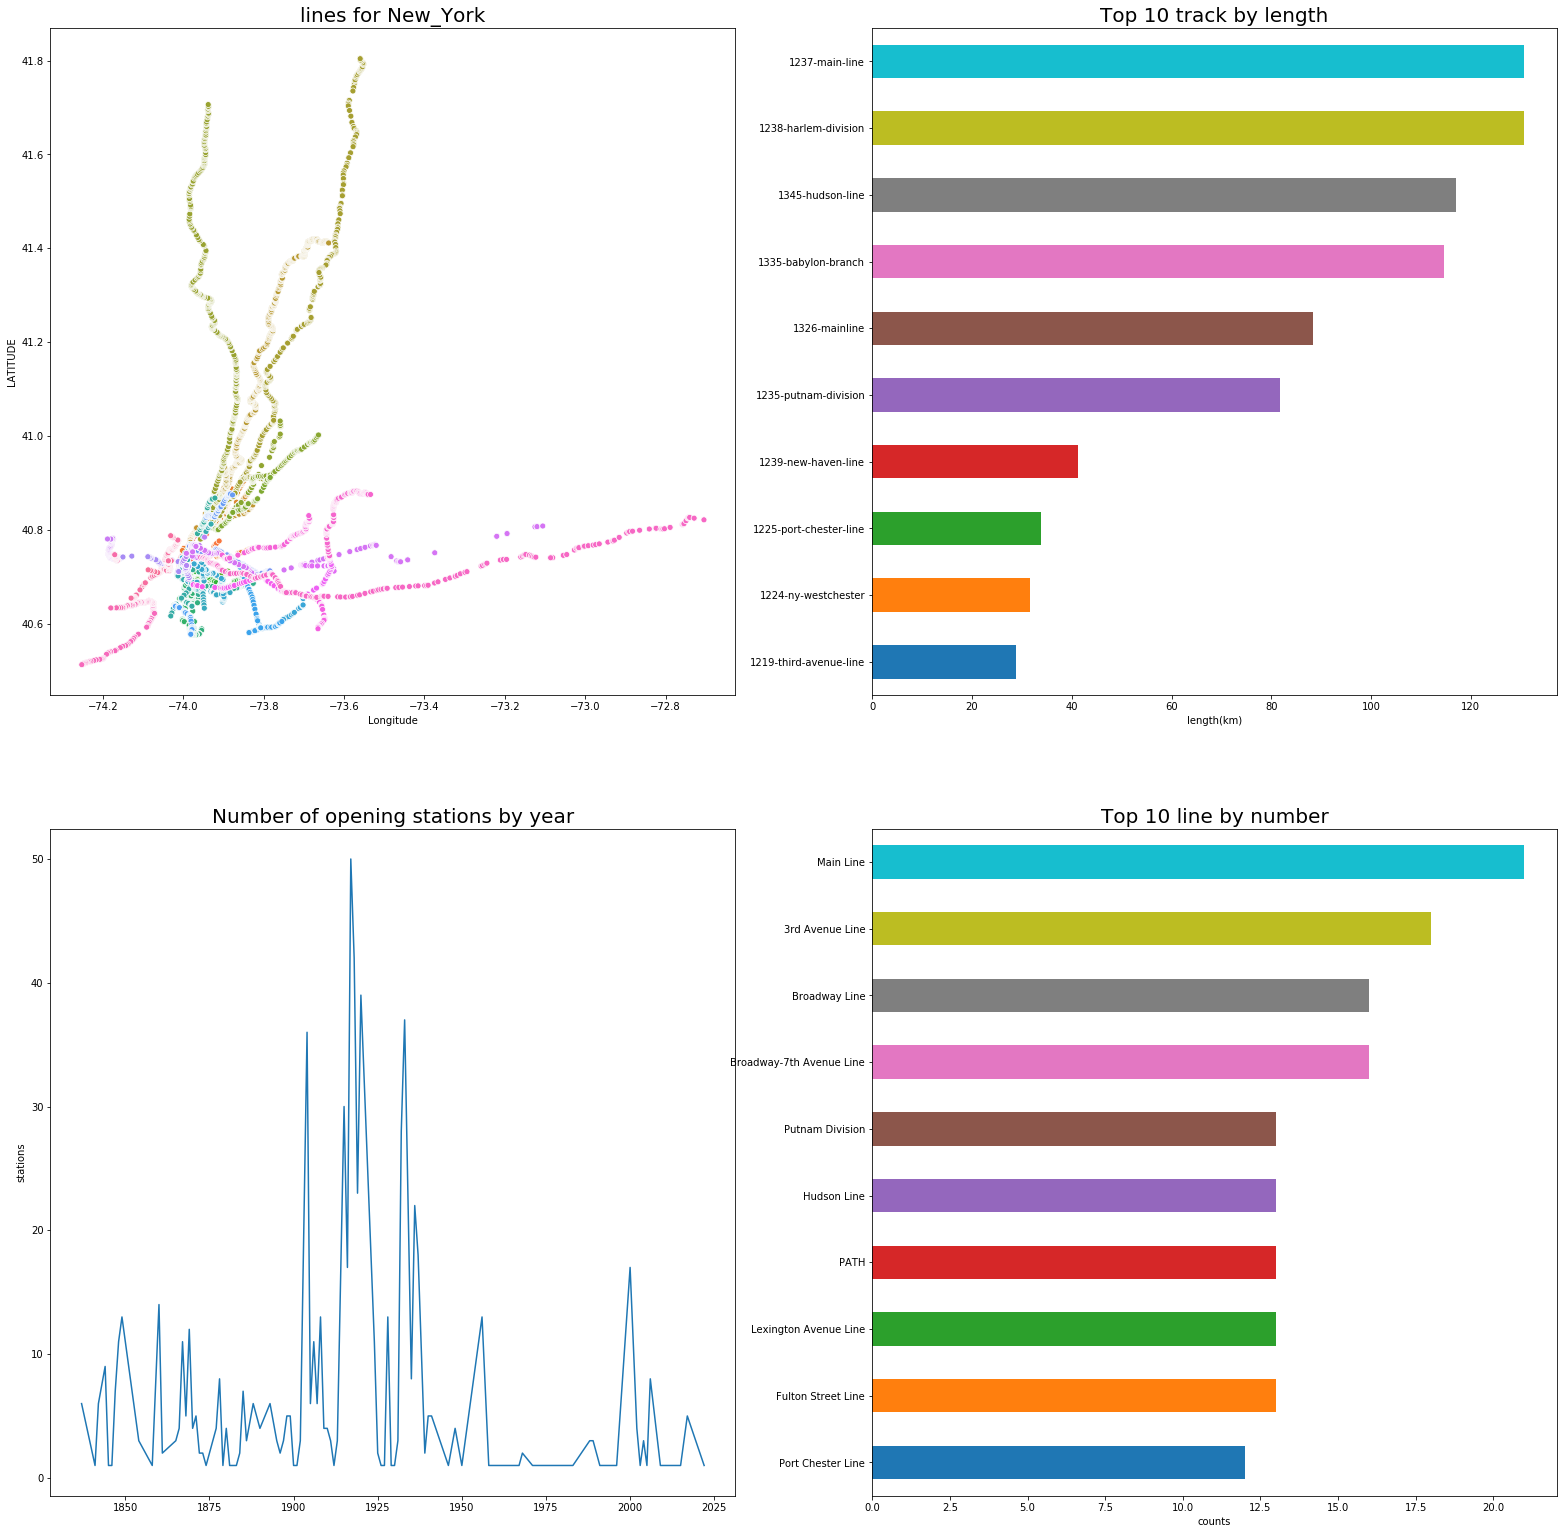

In [16]:
x=[]
y=[]
z=[]
for i in range(len(New_York_lines)):
    sp=New_York_lines.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
    for j in range(len(sp)):
        x.append(sp[j].split(' ')[0])
        y.append(sp[j].split(' ')[1])
        z.append(New_York_lines.url_name[i])
fix=pd.DataFrame({'x':x,'y':y,'z':z})
fix['x']=fix['x'].astype(float)
fix['y']=fix['y'].astype(float)
plt.figure(figsize=(27, 27))
plt.subplot(2, 2, 1) 
ax=sns.scatterplot(x="x", y="y", hue="z",data=fix)
plt.legend(loc=0, bbox_to_anchor=(1.05,0.6))
plt.title("lines for New_York",size=20)
ax.get_legend().remove()
ax.set(xlabel='Longitude', ylabel='LATITUDE')
plt.subplot(2,2,2)
(New_York_lines.groupby(['url_name'])['length'].sum()/1000).sort_values(ascending= False)[:10].sort_values().plot.barh()
plt.ylabel(' ')
plt.xlabel('length(km)')
plt.title("Top 10 track by length",size=20)
plt.subplot(2,2,3)
New_York_stations.groupby(['opening'])['id'].agg('count').plot()
plt.xlabel(' ')
plt.ylabel('stations')
plt.title("Number of opening stations by year",size=20)
plt.subplot(2,2,4)
New_York_lines.name.value_counts()[:10].sort_values().plot.barh()
plt.xlabel('counts')
plt.title("Top 10 line by number",size=20)

In [17]:
stations_New_York=stations[stations['city_id']==206]
Long=-73.97
Lat=40.78
New_York_map=folium.Map([Lat,Long],zoom_start=12)

New_York_stations_map=plugins.MarkerCluster().add_to(New_York_map)
for lat,lon,label in zip(stations_New_York.Lat,stations_New_York.Long,stations_New_York.stations_name):
    folium.Marker(location=[lat,lon],icon=None,popup=label).add_to(New_York_stations_map)
New_York_map.add_child(New_York_stations_map)

New_York_map